In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import pandas as pd
import numpy as np

In [206]:
evictions_by_week = True

evictions = pd.read_csv("dallas_houston_evictions_ACS_10_19.csv")

In [207]:
evictions['count'].max()

71.0

In [208]:
#evictions
if evictions_by_week == True:
    evictions['week_dt'] = pd.to_datetime(evictions['week_dt'])    
    evictions['date_delta'] = (evictions['week_dt'] - evictions['week_dt'].min())  / np.timedelta64(1,'D')


In [180]:
evictions.tail()

,Unnamed: 0,GEOID,count,year,week,week_dt,SE_A03001_003,SE_A18005_001,SE_A06001_005,SE_B18002_002,SE_B18002_003,SE_A08002B_003,SE_A10011_003,SE_A10039B_009,date_delta
460399,723996,48201553002,0.0,2019,52,2019-12-29,902.0,1057.798165,1024.0,125.0,78.0,110.0,232.0,92.0,3647.0
460400,724001,48201553300,74.0,2019,52,2019-12-29,3539.0,1087.017544,689.0,764.0,782.0,2314.0,179.0,640.0,3647.0
460401,724006,48201554301,11.0,2019,52,2019-12-29,716.0,2342.800000,215.0,56.0,75.0,178.0,438.0,0.0,3647.0
460402,724007,48201554302,0.0,2019,52,2019-12-29,1159.0,1341.266376,303.0,159.0,58.0,285.0,219.0,64.0,3647.0
460403,724011,48201980000,2.0,2019,52,2019-12-29,0.0,0.000000,0.0,0.0,4.0,0.0,4.0,0.0,3647.0


In [209]:
evictions['date_delta']

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
           ...  
460399    3647.0
460400    3647.0
460401    3647.0
460402    3647.0
460403    3647.0
Name: date_delta, Length: 460404, dtype: float64

In [402]:
all_evicts = pd.DataFrame({'count':evictions['count'], 'date_delta':evictions['date_delta']})
cov_keep = ["date_delta", "GEOID", "diff", "SE_A03001_003","SE_A06001_005","SE_A08002B_003","SE_A10039B_009","SE_B18002_003","SE_B18002_002","SE_A10011_003"]
#all_covs = evictions.loc[:, evictions.columns.isin(cov_keep)]
all_covs = evictions.filter(cov_keep, axis=1)

In [264]:
evictions['count'].diff().fillna(0)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
460399     0.0
460400    10.0
460401    -9.0
460402    -1.0
460403     0.0
Name: count, Length: 460404, dtype: float64

In [212]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_covs, all_evicts['count'], test_size=0.1, random_state=0)

regressor = DecisionTreeRegressor()

regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [213]:
y_pred = regressor.predict(X_test)
df=y_test.copy()
df['Predicted'] = y_pred
df

234918                                                     2.0
373142                                                     1.0
290116                                                     0.0
361592                                                     0.0
223637                                                     0.0
                                   ...                        
172944                                                     2.0
247102                                                     0.0
95224                                                      3.0
29710                                                      1.0
Predicted    [0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...
Name: count, Length: 46042, dtype: object

In [214]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Max Error:', metrics.max_error(y_test, y_pred))

Mean Absolute Error: 1.3746660585130643
Mean Squared Error: 8.884798331921548
Root Mean Squared Error: 2.9807378838001752
Max Error: 44.0


In [428]:
####################################################################

all_tract_ids = evictions['GEOID'].unique()
by_tract_df = []

for tract in all_tract_ids:
  by_tract_df.append(evictions[evictions['GEOID'] == tract])

all_cov_evicts_by_tract = []
fields = ["evictions", "covariates"]

cov_keep = ["date_delta", "GEOID", "SE_A03001_003","SE_A06001_005","SE_A08002B_003","SE_A10039B_009","SE_B18002_003","SE_B18002_002","SE_A10011_003"]

for tract in by_tract_df:
    if(len(tract) > 100):
        e = pd.DataFrame({'count':tract['count'], 'date_delta':tract['date_delta'], 'diff':tract['count'].diff().fillna(0)})
        c = tract.loc[:, tract.columns.isin(cov_keep)].copy()
        c['diff'] = tract['count'].diff().fillna(0)
        vals = [e,c]
        #vals = [tract['count'], tract.loc[:, tract.columns.isin(cov_keep)]]
        all_cov_evicts_by_tract.append(dict(zip(fields, vals)))


In [216]:
len(all_tract_ids) - len(all_cov_evicts_by_tract)

0

In [217]:
all_means = []
all_mse = []
all_rmse = []
all_max = []
all_tests = []
all_preds = []

for tract in all_cov_evicts_by_tract:

    tract_evict = tract['evictions']
    tract_cov = tract['covariates']

    X_train, X_test, y_train, y_test = train_test_split(tract_cov, tract_evict['count'], test_size=0.2, random_state=0)

    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    all_preds.extend(y_pred)
    all_tests.extend(y_test)

    df=y_test.copy()
    df['Predicted'] = y_pred
    df

    all_means.append(metrics.mean_absolute_error(y_test, y_pred))
    all_mse.append(metrics.mean_squared_error(y_test, y_pred))
    all_rmse.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    all_max.append(metrics.max_error(y_test, y_pred))

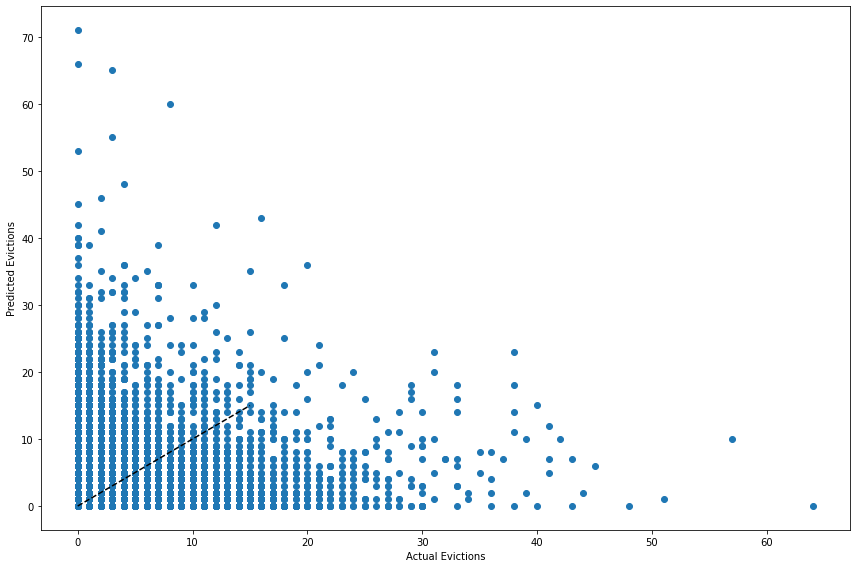

In [218]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(all_preds, all_tests)
plt.plot([0, 15], [0, 15], '--k')
plt.axis('tight')
plt.xlabel('Actual Evictions')
plt.ylabel('Predicted Evictions')
plt.tight_layout()

In [219]:
def print_metrics(means_, mse_, rmse_, max_, value_type):
  print('Avg Mean Absolute Error vs ', value_type, np.mean(means_))
  print('Avg Mean Squared Error vs ', value_type, np.mean(mse_))
  print('Avg Root Mean Squared Error vs ', value_type, np.mean(rmse_))
  print('Avg Max Error vs ', value_type, np.mean(max_))
  print(" --- ")
  print('Max Mean Absolute Error vs ', value_type, np.max(means_))
  print('Max Mean Squared Error vs ', value_type, np.max(mse_))
  print('Max Root Mean Squared Error vs ', value_type, np.max(rmse_))
  print('Max Max Error vs ', value_type, np.max(max_))
  print(" --- ")
  print('Min Mean Absolute Error vs ', value_type, np.min(means_))
  print('Min Mean Squared Error vs ', value_type, np.min(mse_))
  print('Min Root Mean Squared Error vs ', value_type, np.min(rmse_))
  print('Min Max Error vs ', value_type, np.min(max_))


print_metrics(all_means, all_mse, all_rmse, all_max, 'actual')

Avg Mean Absolute Error vs  actual 1.437458157866321
Avg Mean Squared Error vs  actual 9.969690098261529
Avg Root Mean Squared Error vs  actual 2.243353856042358
Avg Max Error vs  actual 8.501133786848072
 --- 
Max Mean Absolute Error vs  actual 12.761904761904763
Max Mean Squared Error vs  actual 305.85714285714283
Max Root Mean Squared Error vs  actual 17.488771908202782
Max Max Error vs  actual 71.0
 --- 
Min Mean Absolute Error vs  actual 0.009523809523809525
Min Mean Squared Error vs  actual 0.009523809523809525
Min Root Mean Squared Error vs  actual 0.09759000729485333
Min Max Error vs  actual 1.0


In [41]:
pip install croston

Note: you may need to restart the kernel to use updated packages.


In [220]:
from croston import croston

evict_count = evictions['count']
fit_pred = croston.fit_croston(evict_count, 10, 'tsb')


In [223]:
all_evicts = pd.DataFrame({'count':fit_pred['croston_fittedvalues']})
cov_keep = ["date_delta", "GEOID", "SE_A03001_003","SE_A06001_005","SE_A08002B_003","SE_A10039B_009","SE_B18002_003","SE_B18002_002","SE_A10011_003"]
all_covs = evictions.loc[:, evictions.columns.isin(cov_keep)]

X_train, X_test, y_train, y_test = train_test_split(all_covs, all_evicts, test_size=0.1, random_state=0)

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
np.count_nonzero(np.isnan(y_pred))

df=y_test.copy()
df['Predicted'] = y_pred
df

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test['count'], y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test['count'], y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test['count'], y_pred)))
print('Max Error:', metrics.max_error(y_test['count'], y_pred))

Mean Absolute Error: 1.0412164297244162
Mean Squared Error: 3.864221628744528
Root Mean Squared Error: 1.965762353069294
Max Error: 27.68412132885554


In [222]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit1 = SimpleExpSmoothing(evictions['count']).fit(smoothing_level=0.1)
fit2 = Holt(evictions['count']).fit()
fit3 = Holt(evictions['count']).fit(
    smoothing_level=0.5
)

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [224]:
all_evicts = pd.DataFrame()
all_evicts.ignore_index=True
all_evicts['count'] = fit1.fittedvalues

cov_keep = ["date_delta", "GEOID", "SE_A03001_003", "SE_A06001_005", "SE_A08002B_003", "SE_A10039B_009", "SE_B18002_003", "SE_B18002_002", "SE_A10011_003"]
all_covs = evictions.loc[:, evictions.columns.isin(cov_keep)]

X_train, X_test, y_train, y_test = train_test_split(all_covs, all_evicts['count'], test_size=0.1, random_state=0)

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
np.count_nonzero(np.isnan(y_pred))

df=y_test.copy()
df['Predicted'] = y_pred
df

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Max Error:', metrics.max_error(y_test, y_pred))

Mean Absolute Error: 0.499378220447229
Mean Squared Error: 0.6851059990447431
Root Mean Squared Error: 0.8277113017500384
Max Error: 8.156048516464868


# How do we do predicting within a tract?

This splits each tracts into a test/train segment, creates a model for the train portion of that tract and predicts our test portion of the tract.

In [261]:
%%capture

all_means = []
all_mse = []
all_rmse = []
all_max = []

all_means_actual = []
all_mse_actual = []
all_rmse_actual = []
all_max_actual = []

all_preds = []
all_tests = []
all_actuals = []

for tract in all_cov_evicts_by_tract:
    fitted = SimpleExpSmoothing(tract['evictions']['count']).fit(smoothing_level=0.1)
    tract_evicts = pd.DataFrame()
    tract_evicts.ignore_index=True
    tract_evicts['fitted'] = fitted.fittedvalues
    tract_evicts['actual'] = tract['evictions']['count']
    tract_cov = tract['covariates']

    X_train, X_test, y_train, y_test = train_test_split(tract_cov, tract_evicts, test_size=0.2, random_state=0)

    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train['fitted'])

    y_pred = regressor.predict(X_test)

    all_tests.extend(y_test['fitted'])
    all_preds.extend(y_pred)
    all_actuals.extend(y_test['actual'])

    all_means.append(metrics.mean_absolute_error(y_test['fitted'], y_pred))
    all_mse.append(metrics.mean_squared_error(y_test['fitted'], y_pred))
    all_rmse.append(np.sqrt(metrics.mean_squared_error(y_test['fitted'], y_pred)))
    all_max.append(metrics.max_error(y_test['fitted'], y_pred))

    all_means_actual.append(metrics.mean_absolute_error(y_test['actual'], y_pred))
    all_mse_actual.append(metrics.mean_squared_error(y_test['actual'], y_pred))
    all_rmse_actual.append(np.sqrt(metrics.mean_squared_error(y_test['actual'], y_pred)))
    all_max_actual.append(metrics.max_error(y_test['actual'], y_pred))



In [226]:
print_metrics(all_means, all_mse, all_rmse, all_max, "smoothed")
print(" ")
print_metrics(all_means_actual, all_mse_actual, all_rmse_actual, all_max_actual, 'actual')

Avg Mean Absolute Error vs  smoothed 0.11273987007137978
Avg Mean Squared Error vs  smoothed 0.049183261269215205
Avg Root Mean Squared Error vs  smoothed 0.15812878765322277
Avg Max Error vs  smoothed 0.6697128769860706
 --- 
Max Mean Absolute Error vs  smoothed 0.892974213441764
Max Mean Squared Error vs  smoothed 1.47862749857431
Max Root Mean Squared Error vs  smoothed 1.215988280607305
Max Max Error vs  smoothed 5.88055538867231
 --- 
Min Mean Absolute Error vs  smoothed 0.0005623353907912909
Min Mean Squared Error vs  smoothed 2.2908248815216415e-06
Min Root Mean Squared Error vs  smoothed 0.0015135471190292167
Min Max Error vs  smoothed 0.007290000654749607
 
Avg Mean Absolute Error vs  actual 1.1078648586457687
Avg Mean Squared Error vs  actual 4.756519647144459
Avg Root Mean Squared Error vs  actual 1.5693851310526656
Avg Max Error vs  actual 6.697534444330411
 --- 
Max Mean Absolute Error vs  actual 8.766955153396031
Max Mean Squared Error vs  actual 143.1977175401729
Max Roo

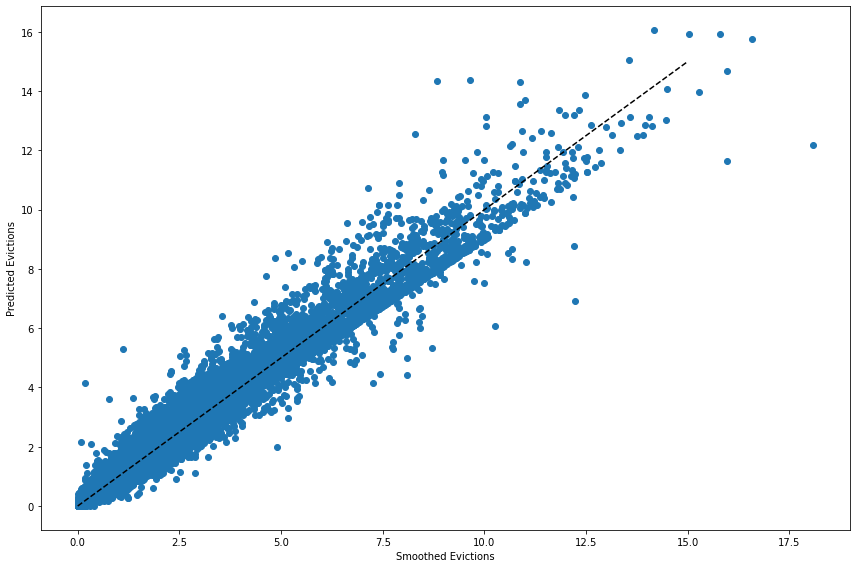

In [227]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(all_preds, all_tests)
plt.plot([0, 15], [0, 15], '--k')
plt.axis('tight')
plt.xlabel('Smoothed Evictions')
plt.ylabel('Predicted Evictions')
plt.tight_layout()

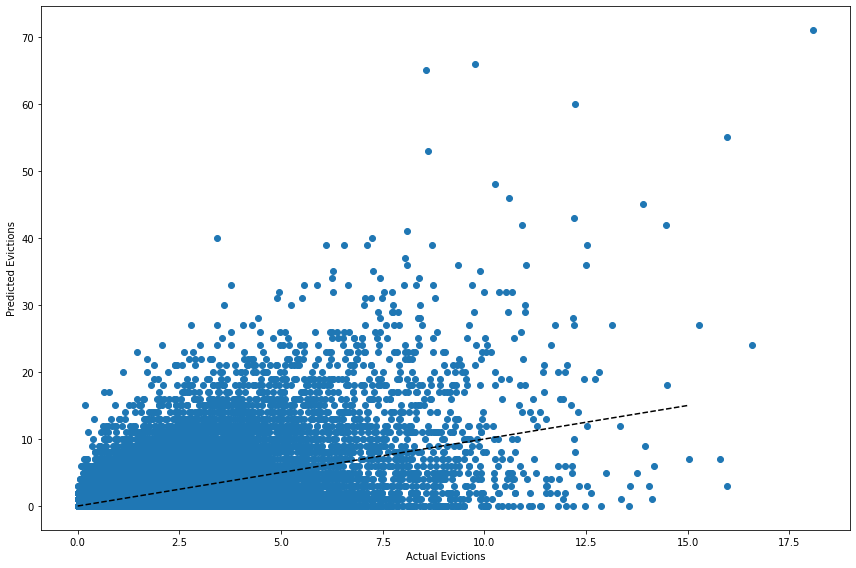

In [228]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(all_preds, all_actuals)
plt.plot([0, 15], [0, 15], '--k')
plt.axis('tight')
plt.xlabel('Actual Evictions')
plt.ylabel('Predicted Evictions')
plt.tight_layout()

# How do we do predicting between tracts?

e.g. does one tract help us predict another?

In [297]:
%%capture
# need to suppress output so that SimpleExpSmoothing.fit doesn't throw a fit

all_means = []
all_mse = []
all_rmse = []
all_max = []

all_means_actual = []
all_mse_actual = []
all_rmse_actual = []
all_max_actual = []

all_preds = []
all_tests = []
all_actuals = []


train_tracts, test_tracts = train_test_split(all_cov_evicts_by_tract, test_size=0.1, random_state=0)

regressor = DecisionTreeRegressor()

train_y = []
train_X = []

for tract in train_tracts:
    fitted = SimpleExpSmoothing(tract['evictions']['count']).fit()
    tract_evicts = pd.DataFrame()
    tract_evicts.ignore_index=True
    tract_evicts['fitted'] = fitted.fittedvalues
    tract_evicts['diff'] = tract['evictions']['diff']
    tract_evicts['actual'] = tract['evictions']['count']
    tract_cov = tract['covariates'].to_numpy()
    train_y.extend(tract_evicts['diff'])
    train_X.extend(tract_cov)

regressor.fit(train_X, train_y)

for tract in test_tracts:
    fitted = SimpleExpSmoothing(tract['evictions']['count']).fit()
    tract_evicts = pd.DataFrame()
    tract_evicts.ignore_index=True
    tract_evicts['fitted'] = fitted.fittedvalues
    tract_evicts['diff'] = tract['evictions']['diff']
    tract_evicts['actual'] = tract['evictions']['count']
    tract_cov = tract['covariates'].to_numpy()

    y_pred = regressor.predict(tract_cov)

    all_tests.extend(tract_evicts['diff'])
    all_preds.extend(y_pred)
    #all_actuals.extend(y_test['actual'])

    all_means.append(metrics.mean_absolute_error(tract_evicts['fitted'], y_pred))
    all_mse.append(metrics.mean_squared_error(tract_evicts['fitted'], y_pred))
    all_rmse.append(np.sqrt(metrics.mean_squared_error(tract_evicts['fitted'], y_pred)))
    all_max.append(metrics.max_error(tract_evicts['fitted'], y_pred))

    all_means_actual.append(metrics.mean_absolute_error(tract_evicts['actual'], y_pred))
    all_mse_actual.append(metrics.mean_squared_error(tract_evicts['actual'], y_pred))
    all_rmse_actual.append(np.sqrt(metrics.mean_squared_error(tract_evicts['actual'], y_pred)))
    all_max_actual.append(metrics.max_error(tract_evicts['actual'], y_pred))


In [298]:
print_metrics(all_means, all_mse, all_rmse, all_max, 'smoothed')
print(" ")
print_metrics(all_means_actual, all_mse_actual, all_rmse_actual, all_max_actual, 'actual')

Avg Mean Absolute Error vs  smoothed 2.32575353564883
Avg Mean Squared Error vs  smoothed 16.383593918374505
Avg Root Mean Squared Error vs  smoothed 3.38189308646473
Avg Max Error vs  smoothed 20.54804794083323
 --- 
Max Mean Absolute Error vs  smoothed 10.815230979162767
Max Mean Squared Error vs  smoothed 162.02429308207718
Max Root Mean Squared Error vs  smoothed 12.728876347976563
Max Max Error vs  smoothed 46.8292055457861
 --- 
Min Mean Absolute Error vs  smoothed 0.157748723798553
Min Mean Squared Error vs  smoothed 0.19763496317334212
Min Root Mean Squared Error vs  smoothed 0.4445615403668452
Min Max Error vs  smoothed 3.964861600412838
 
Avg Mean Absolute Error vs  actual 2.410844203366482
Avg Mean Squared Error vs  actual 21.753174910672005
Avg Root Mean Squared Error vs  actual 3.79874062285163
Avg Max Error vs  actual 22.51685393258427
 --- 
Max Mean Absolute Error vs  actual 11.446360153256705
Max Mean Squared Error vs  actual 247.31226053639847
Max Root Mean Squared Err

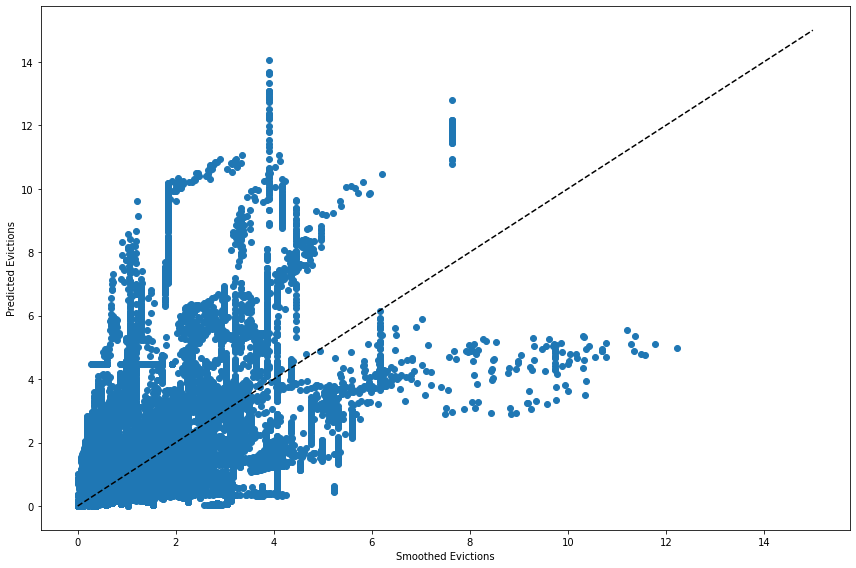

In [231]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(all_preds, all_tests)
plt.plot([0, 15], [0, 15], '--k')
plt.axis('tight')
plt.xlabel('Smoothed Evictions')
plt.ylabel('Predicted Evictions')
plt.tight_layout()

# How do we do forecasting?

In [232]:
all_cov_evicts_by_tract[0]['evictions']['date_delta']

0            0.0
882          7.0
1764        14.0
2646        21.0
3528        28.0
           ...  
455994    3619.0
456876    3626.0
457758    3633.0
458640    3640.0
459522    3647.0
Name: date_delta, Length: 522, dtype: float64

In [429]:
%%capture
# need to suppress output so that SimpleExpSmoothing.fit doesn't throw a fit

from sklearn.model_selection import TimeSeriesSplit

all_means = []
all_mse = []
all_rmse = []
all_max = []

all_preds = []
all_tests = []

all_test = []
all_train = []

tract_y = []
tract_X = []

for tract in all_cov_evicts_by_tract:
    fitted = SimpleExpSmoothing(tract['evictions']['count']).fit(smoothing_level=0.1)
    tract_evicts = pd.DataFrame()
    tract_evicts.ignore_index=True
    tract_evicts['fitted'] = fitted.fittedvalues
    tract_evicts['diff'] = tract['evictions']['diff']
    tract_evicts['actual'] = tract['evictions']['count']
    tract_evicts['date_delta'] = tract['evictions']['date_delta']
    tract_y.append(tract_evicts)
    tract_cov = tract['covariates']
    tract_X.append(tract_cov)

X_train = []
X_test = []
y_train = []
y_test = []

# split so we're predicting 10 weeks forward
date_delta_split = 2577

for cov in tract_X:
    X_train.extend(cov[cov['date_delta'] < date_delta_split].to_numpy())
    X_test.extend(cov[cov['date_delta'] > date_delta_split].to_numpy())

for ev in tract_y:
    y_train.extend(ev[ev['date_delta'] < date_delta_split]['fitted'])
    y_test.extend(ev[ev['date_delta'] > date_delta_split]['fitted'])


In [430]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

all_tests.extend(y_test)
all_preds.extend(y_pred)
all_actuals.extend(y_test)

all_means.append(metrics.mean_absolute_error(y_test, y_pred))
all_mse.append(metrics.mean_squared_error(y_test, y_pred))
all_rmse.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
all_max.append(metrics.max_error(y_test, y_pred))

In [431]:
#print_metrics(all_means, all_mse, all_rmse, all_max, 'smoothed')
y_pred[500:600]

array([0.217697, 0.217697, 0.217697, 0.217697, 0.298625, 0.217697,
       0.141095, 0.683761, 0.053558, 0.048202, 0.048202, 0.200107,
       0.053558, 0.053558, 0.048202, 1.628786, 0.048202, 1.628786,
       0.703950, 1.628786, 0.053558, 1.628786, 0.053558, 0.053558,
       0.053558, 0.053558, 0.053558, 0.703950, 0.053558, 0.200107,
       0.053558, 0.048202, 1.628786, 0.053558, 0.053558, 0.048202,
       1.628786, 0.703950, 0.200107, 0.053558, 0.053558, 0.053558,
       0.048202, 1.628786, 0.053558, 0.703950, 0.200107, 0.053558,
       0.053558, 0.048202, 1.628786, 0.053558, 0.053558, 0.053558,
       0.053558, 0.053558, 0.048202, 1.628786, 0.048202, 0.053558,
       1.628786, 0.053558, 0.053558, 0.053558, 0.369282, 0.463015,
       0.053558, 0.053558, 0.053558, 0.053558, 0.053558, 0.053558,
       0.053558, 0.369282, 0.463015, 0.053558, 0.053558, 0.053558,
       0.053558, 0.053558, 0.053558, 0.048202, 1.628786, 0.053558,
       0.369282, 1.628786, 1.628786, 0.053558, 0.053558, 0.053

In [432]:
print(all_means)
print(all_mse)
print(all_rmse)
print(all_max)

[0.5798080315383137]
[1.1581347184129667]
[1.0761666778027308]
[11.851156460814288]


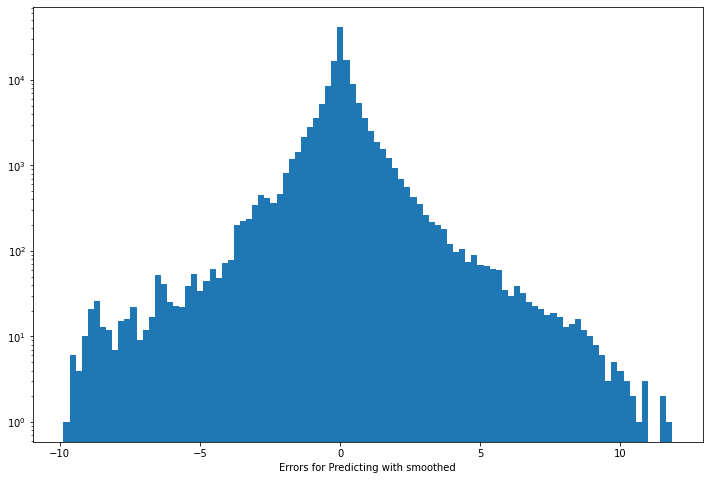

In [435]:
plt.figure(figsize=(12, 8))
plt.xlabel('Errors for Predicting with smoothed')
plt.hist(np.subtract(y_test, y_pred), bins=100, log=True)
plt.show()

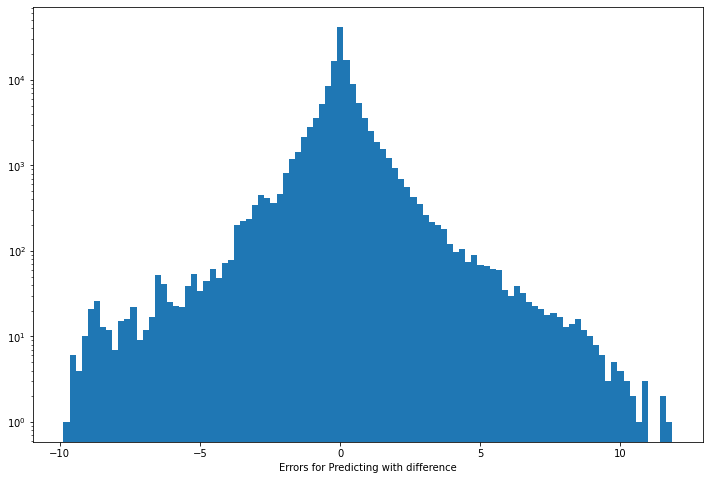

In [436]:
plt.figure(figsize=(12, 8))
plt.xlabel('Errors for Predicting with difference')
plt.hist(np.subtract(y_test, y_pred), bins=100, log=True)
plt.show()

In [447]:
def _error(actual: np.ndarray, predicted: np.ndarray):
    return np.subtract(actual, predicted)

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    return actual[:-seasonality]

def mae(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_error(actual, predicted)))

def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))

print(mase(y_test, y_pred))

5.194910152907186


In [437]:
np.argmax(np.abs(np.subtract(y_pred, y_test)))

55691

In [438]:
np.argmin(np.abs(np.subtract(y_pred, y_test)))

134793

In [440]:
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})


X_test[55691]

array([48113016607.000000, 3334.000000, 101.000000, 662.000000,
       629.000000, 857.000000, 502.000000, 533.000000, 3647.000000,
       -71.000000])

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<Figure size 864x576 with 0 Axes>

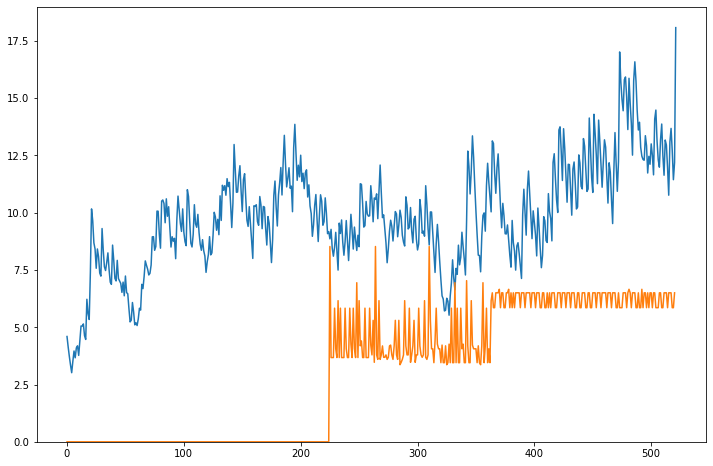

In [466]:
worst_geoid = 48113016607

fitted = SimpleExpSmoothing(evictions[evictions['GEOID'] == worst_geoid]['count']).fit(smoothing_level=0.1)
cov_keep = ["date_delta", "diff", "GEOID", "SE_A03001_003","SE_A06001_005","SE_A08002B_003","SE_A10039B_009","SE_B18002_003","SE_B18002_002","SE_A10011_003"]
worst_covs = evictions[evictions['GEOID'] == worst_geoid].filter(cov_keep, axis=1)
worst_covs['diff'] = evictions[evictions['GEOID'] == worst_geoid]['count'].diff().fillna(0)

date_delta_split = 1577

worst_covs_test = []
worst_covs_test.extend(worst_covs[worst_covs['date_delta'] > date_delta_split].to_numpy())

worst_y = evictions[(evictions['GEOID'] == worst_geoid) & (evictions['date_delta'] > date_delta_split)]['count'].to_numpy()

worst_padding = [0] * int(date_delta_split / 7)

worst_pred = regressor.predict(worst_covs_test)

worst_padding.extend(worst_pred * 1.5)
ff = fitted.fittedvalues.reset_index()

plt.figure(figsize=(12, 8))
f, ax = plt.subplots(1, figsize=(12, 8))
plt.plot(ff[0], label="Actual")
plt.plot(worst_padding, label="Predicted")
ax.set_ylim(bottom=0)
plt.show()

In [409]:
np.sqrt(metrics.mean_squared_error(worst_y, worst_pred))

24.20139091415108

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<Figure size 864x576 with 0 Axes>

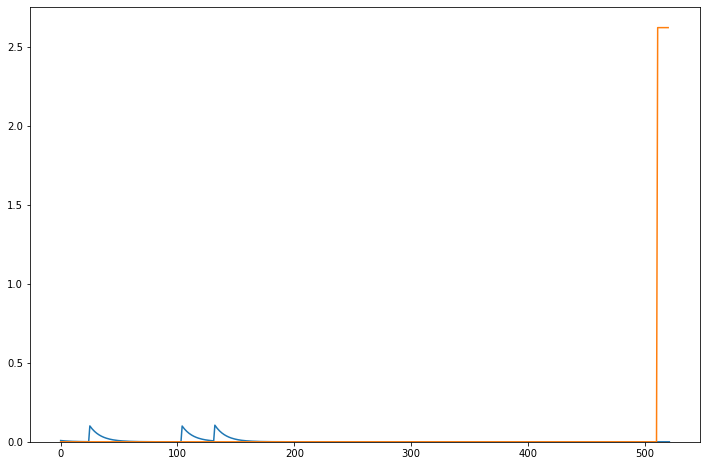

In [459]:
fitted = SimpleExpSmoothing(evictions[evictions['GEOID'] == 48201411400]['count']).fit(smoothing_level=0.1)
cov_keep = ["date_delta", "GEOID", "SE_A03001_003","SE_A06001_005","SE_A08002B_003","SE_A10039B_009","SE_B18002_003","SE_B18002_002","SE_A10011_003"]
best_covs = evictions[evictions['GEOID'] == 48201411400].filter(cov_keep, axis=1)
best_covs['diff'] = evictions[evictions['GEOID'] == 48201411400]['count'].diff().fillna(0)


date_delta_split = 3577

best_covs_test = []
best_covs_test.extend(best_covs[best_covs['date_delta'] > date_delta_split].to_numpy())
best_y = evictions[(evictions['GEOID'] == 48201411400) & (evictions['date_delta'] > date_delta_split)]['count'].to_numpy()


padding = buckets = [0] * int(date_delta_split / 7)

best_pred = regressor.predict(best_covs_test)

padding.extend(best_pred)
ff = fitted.fittedvalues.reset_index()

plt.figure(figsize=(12, 8))
f, ax = plt.subplots(1, figsize=(12, 8))
plt.plot(ff[0], label="Actual")
plt.plot(padding, label="Predicted")
ax.set_ylim(bottom=0)
plt.show()

In [411]:
np.sqrt(metrics.mean_squared_error(best_y, best_pred))

1.4343369583770122

In [ ]:
fitted = SimpleExpSmoothing(evictions[evictions['GEOID'] == 48113016607]['count']).fit(smoothing_level=0.1)
cov_keep = ["date_delta", "GEOID", "SE_A03001_003","SE_A06001_005","SE_A08002B_003","SE_A10039B_009","SE_B18002_003","SE_B18002_002","SE_A10011_003"]
worst_covs = evictions[evictions['GEOID'] == 48113016607].filter(cov_keep, axis=1)

date_delta_split = 3577

worst_covs_test = []
worst_covs_test.extend(worst_covs[worst_covs['date_delta'] > date_delta_split].to_numpy())

padding = buckets = [0] * int(3577 / 7)

worst_pred = regressor.predict(worst_covs_test)

padding.extend(worst_pred)
ff = fitted.fittedvalues.reset_index()

In [ ]:
plt.figure(figsize=(12, 8))
f, ax = plt.subplots(1, figsize=(12, 8))
plt.plot(ff[0], label="Actual")
plt.plot(padding, label="Predicted")
ax.set_ylim(bottom=0)
plt.show()

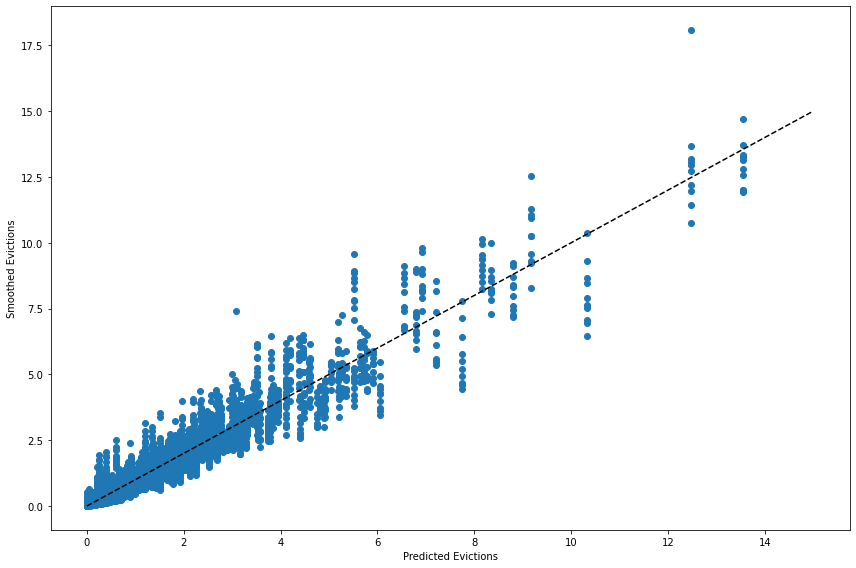

In [361]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(all_preds, all_tests)
plt.plot([0, 15], [0, 15], '--k')
plt.axis('tight')
plt.xlabel('Predicted Evictions')
plt.ylabel('Smoothed Evictions')
plt.tight_layout()

PLEASE IGNORE BELOW, NOT USING